# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import random
import csv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.contrib.layers import flatten

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

print('Loaded all imports!')

Loaded all imports!


In [10]:
# Load pickled data

training_file   = './train.p'
validation_file = './valid.p'
testing_file    = './test.p'
names_file      = './signnames.csv'

with open(names_file) as f:
    reader = csv.reader(f)
    next(reader) # skip first row
    names = {int(rows[0]):rows[1] for rows in reader}

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test   =  test['features'],  test['labels']

print('all done')

all done


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

### Include an exploratory visualization of the dataset

In [3]:


# Number of training examples
n_train = np.shape(X_train)[0]

# Number of validation examples
n_validation = np.shape(X_valid)[0]

# Number of testing examples.
n_test = np.shape(X_test)[0]

# What's the shape of an traffic sign image?
image_shape = np.shape(X_train[0])

# How many unique classes/labels there are in the dataset.
num_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", num_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


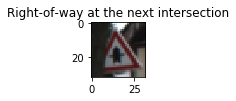

20


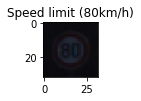

9


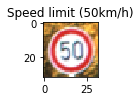

2


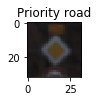

16


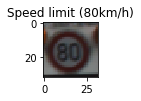

17


In [31]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for x in range(5):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()

    plt.figure(figsize=(1,1))
    plt.title(names[y_train[index]])
    #plt.subplot(1,10,x+1)
    plt.imshow(image) # showing with cmap='gray' does not seem to have any affect
    plt.show()
    print(y_train[x])

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [54]:
X_train, y_train = shuffle(X_train, y_train)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

print('shuffled up and traing/validation sets ready')

shuffled up and traing/validation sets ready


In [53]:
def normalize(pixels):
    return (pixels - 128) / 128

X_train = normalize(X_train)
X_validation = normalize(X_validation)
X_test = normalize(X_test)

print('Images are now roughly normalized, hooray!')

Images are now roughly normalized, hooray!


### Model Architecture

In [63]:

EPOCHS = 500
BATCH_SIZE = 1024 #orig 128
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.16

# Declaring weights outside method for access later.  CLEANME: Move this to a proper class
depth_conv1 = 6
depth_conv2 = 16
size_fc_1 = 120
size_fc_2 = 84

conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, depth_conv1), mean = mu, stddev = sigma))
conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, depth_conv1, depth_conv2), mean = mu, stddev = sigma))
fc1_W = tf.Variable(tf.truncated_normal(shape=(5*5*depth_conv2, size_fc_1), mean = mu, stddev = sigma))
fc2_W  = tf.Variable(tf.truncated_normal(shape=(size_fc_1, size_fc_2), mean = mu, stddev = sigma))
fc3_W  = tf.Variable(tf.truncated_normal(shape=(size_fc_2, num_classes), mean = mu, stddev = sigma))
keep_prob = tf.placeholder(tf.float32) # probability to keep units

def LeNet(x):    
    print("Charging up!")

    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28xdepth_conv1.
    conv1_b = tf.Variable(tf.zeros(depth_conv1))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    #conv1 =  tf.nn.dropout(conv1, keep_prob)
    
    # Pooling. Input = 28x28xdepth_conv1. Output = 14x14xdepth_conv1.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10xdepth_conv2.
    conv2_b = tf.Variable(tf.zeros(depth_conv2))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    #conv2 = tf.nn.dropout(conv2, keep_prob)

    # Pooling. Input = 10x10xdepth_conv2. Output = 5x5xdepth_conv2.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5xdepth_conv2. Output = 1800.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 1800. Output = size_fc_1.
    fc1_b = tf.Variable(tf.zeros(size_fc_1))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1    = tf.nn.dropout(fc1, keep_prob)
    
    # Layer 3: Fully Connected. Input = size_fc_1. Output = size_fc_2.
    fc2_b  = tf.Variable(tf.zeros(size_fc_2))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob)

    # Layer 4: Fully Connected. Input = size_fc_2. Output = num_classes.
    fc3_b  = tf.Variable(tf.zeros(num_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, num_classes)

print('All done')

All done


### Train, Validate and Test the Model

In [ ]:
%%time

rate = 0.001
largeBiasPenalty = 0.039
keep_probability = 0.65

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)

loss_operation = tf.reduce_mean(cross_entropy)

# Add regularization to the loss for highly-biased weights
#blah = \
loss_operation += \
    largeBiasPenalty * tf.nn.l2_loss(conv1_W) +\
    largeBiasPenalty * tf.nn.l2_loss(conv2_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc1_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc2_W) +\
    largeBiasPenalty * tf.nn.l2_loss(fc3_W)

optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        print("EPOCH {} ...".format(i+1))
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: keep_probability})

        training_accuracy = evaluate(X_train, y_train)    
        validation_accuracy = evaluate(X_validation, y_validation)

        print("Training = {:.3f} vs Validation Accuracy = {:.3f}".format(training_accuracy, validation_accuracy))
        print("Spread: {:.3f}".format(training_accuracy - validation_accuracy)) 
        # ^^ AKA: how much accuracy (de/in)creased by on validation
        saver.save(sess, './traffick')
        print("Model saved")
        print()
        
    

### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

Charging up!
Training...

EPOCH 1 ...
Training = 0.043 vs Validation Accuracy = 0.043
Spread: 0.001
Model saved

EPOCH 2 ...
Training = 0.046 vs Validation Accuracy = 0.047
Spread: -0.002
Model saved

EPOCH 3 ...
Training = 0.050 vs Validation Accuracy = 0.051
Spread: -0.001
Model saved

EPOCH 4 ...
Training = 0.063 vs Validation Accuracy = 0.059
Spread: 0.004
Model saved

EPOCH 5 ...
Training = 0.065 vs Validation Accuracy = 0.062
Spread: 0.003
Model saved

EPOCH 6 ...
Training = 0.064 vs Validation Accuracy = 0.060
Spread: 0.004
Model saved

EPOCH 7 ...
Training = 0.065 vs Validation Accuracy = 0.056
Spread: 0.009
Model saved

EPOCH 8 ...
Training = 0.058 vs Validation Accuracy = 0.057
Spread: 0.002
Model saved

EPOCH 9 ...
Training = 0.060 vs Validation Accuracy = 0.057
Spread: 0.003
Model saved

EPOCH 10 ...
Training = 0.067 vs Validation Accuracy = 0.062
Spread: 0.005
Model saved

EPOCH 11 ...
Training = 0.072 vs Validation Accuracy = 0.065
Spread: 0.007
Model saved

EPOCH 12 ...


Training = 0.362 vs Validation Accuracy = 0.332
Spread: 0.030
Model saved

EPOCH 95 ...
Training = 0.372 vs Validation Accuracy = 0.352
Spread: 0.020
Model saved

EPOCH 96 ...
Training = 0.369 vs Validation Accuracy = 0.347
Spread: 0.022
Model saved

EPOCH 97 ...
Training = 0.379 vs Validation Accuracy = 0.361
Spread: 0.018
Model saved

EPOCH 98 ...
Training = 0.378 vs Validation Accuracy = 0.350
Spread: 0.027
Model saved

EPOCH 99 ...
Training = 0.369 vs Validation Accuracy = 0.349
Spread: 0.020
Model saved

EPOCH 100 ...
Training = 0.383 vs Validation Accuracy = 0.362
Spread: 0.021
Model saved

EPOCH 101 ...
Training = 0.383 vs Validation Accuracy = 0.364
Spread: 0.019
Model saved

EPOCH 102 ...
Training = 0.392 vs Validation Accuracy = 0.362
Spread: 0.030
Model saved

EPOCH 103 ...
Training = 0.394 vs Validation Accuracy = 0.369
Spread: 0.025
Model saved

EPOCH 104 ...
Training = 0.408 vs Validation Accuracy = 0.388
Spread: 0.021
Model saved

EPOCH 105 ...
Training = 0.408 vs Valida

Model saved

EPOCH 187 ...
Training = 0.483 vs Validation Accuracy = 0.459
Spread: 0.023
Model saved

EPOCH 188 ...
Training = 0.485 vs Validation Accuracy = 0.464
Spread: 0.021
Model saved

EPOCH 189 ...
Training = 0.499 vs Validation Accuracy = 0.473
Spread: 0.025
Model saved

EPOCH 190 ...
Training = 0.489 vs Validation Accuracy = 0.468
Spread: 0.020
Model saved

EPOCH 191 ...
Training = 0.505 vs Validation Accuracy = 0.481
Spread: 0.024
Model saved

EPOCH 192 ...
Training = 0.490 vs Validation Accuracy = 0.475
Spread: 0.015
Model saved

EPOCH 193 ...
Training = 0.496 vs Validation Accuracy = 0.473
Spread: 0.023
Model saved

EPOCH 194 ...
Training = 0.494 vs Validation Accuracy = 0.477
Spread: 0.017
Model saved

EPOCH 195 ...
Training = 0.501 vs Validation Accuracy = 0.480
Spread: 0.021
Model saved

EPOCH 196 ...
Training = 0.495 vs Validation Accuracy = 0.482
Spread: 0.013
Model saved

EPOCH 197 ...
Training = 0.494 vs Validation Accuracy = 0.472
Spread: 0.022
Model saved

EPOCH 19

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [62]:
%%time

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

Test Accuracy = 0.685
CPU times: user 3.08 s, sys: 1.35 s, total: 4.43 s
Wall time: 2.89 s


### Load and Output the Images

size of tank: (32, 32, 3) 


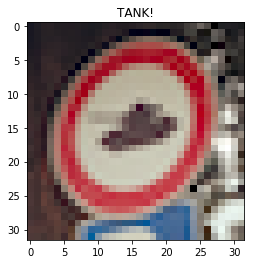

size of animal: (32, 32, 3) 


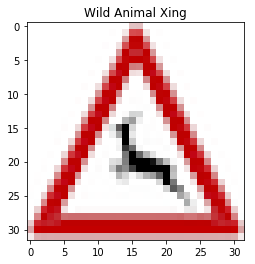

size of general_caution: (32, 32, 3) 


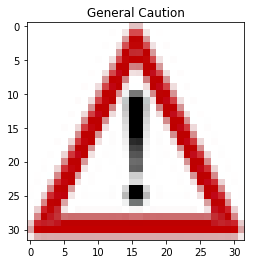

size of dangerous_left: (32, 32, 3) 


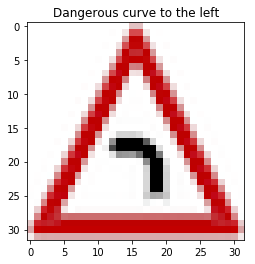

size of kph_60: (32, 32, 3) 


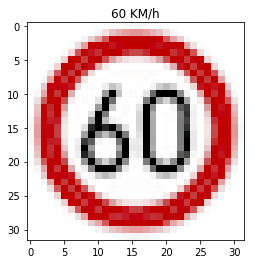

size of kph_30: (32, 32, 3) 


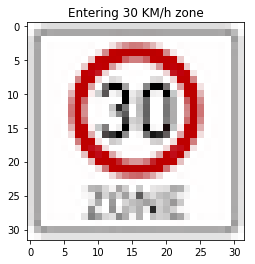

(6, 32, 32, 3)


In [38]:
# class id = NONE!
tank = mpimg.imread('downloaded/tank.png')
print('size of tank: {} '.format(np.shape(tank)))

# It seems like mpimg is already 'normalizing' the images as we read them.  Or it was OSX Preview as I reshapped the classes.
#print('full output of tank: {}'.format(tank))
#print('normalizing tank: {}'.format(normalize(tank)))

plt.title('TANK!')
plt.imshow(tank)
plt.show()

# class id = 31
wild_animals = mpimg.imread('downloaded/847px-Zeichen_142-10_-_Wildwechsel,_Aufstellung_rechts,_StVO_1992.svg.png')
print('size of animal: {} '.format(np.shape(wild_animals)))
plt.title('Wild Animal Xing')
plt.imshow(wild_animals)
plt.show()

# class id = 18
general_caution = mpimg.imread('downloaded/Zeichen_101_-_Gefahrstelle,_StVO_1970.svg.png')
print('size of general_caution: {} '.format(np.shape(general_caution)))
plt.title('General Caution')
plt.imshow(general_caution)
plt.show()

# class id = 19
dangerous_left = mpimg.imread('downloaded/Zeichen_103-10_-_Kurve_(links),_StVO_1992.svg.png')
print('size of dangerous_left: {} '.format(np.shape(dangerous_left)))
plt.title('Dangerous curve to the left')
plt.imshow(dangerous_left)
plt.show()


# class id = 3
kph_60 = mpimg.imread('downloaded/Zeichen_274-56.svg.png')
print('size of kph_60: {} '.format(np.shape(kph_60)))
plt.title('60 KM/h')
plt.imshow(kph_60)
plt.show()

# class id 1
kph_30 = mpimg.imread('downloaded/Zeichen_274.1_-_Beginn_einer_Tempo_30-Zone,_StVO_2013.svg.png')
print('size of kph_30: {} '.format(np.shape(kph_30)))
plt.title('Entering 30 KM/h zone')
plt.imshow(kph_30)
plt.show()



X_downloaded = [tank, wild_animals, general_caution, dangerous_left, kph_60, kph_30]
y_downloaded = [-1,31,18,19,3,1]

print(np.shape(X_downloaded))

### Predict the Sign Type for Each Image

In [39]:
%%time

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_downloaded, y_downloaded)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

TypeError: Cannot interpret feed_dict key as Tensor: Can not convert a int into a Tensor.

### Analyze Performance

In [18]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

# function to print out softmax
# It may be a bit more optimized to run this during accuracy option. But not needed for this project's purposes

top5 = tf.nn.top_k(tf.nn.softmax(logits), k=5)

def eval_downloaded(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    t5 = sess.run(top5, feed_dict={x: X_data, y: y_data, keep_prob: 1.0})
    print("TOP5   {}".format(t5))
    return t5

print('Eval with top5 function loaded')

Eval with top5 function loaded


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

In [19]:
%%time

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top5_accuracy = eval_downloaded(X_downloaded, y_downloaded)
    print("top 5 matrix in full = {}".format(top5_accuracy))

TOP5   TopKV2(values=array([[ 0.07880038,  0.07310821,  0.06941397,  0.06665935,  0.05574323],
       [ 0.18581203,  0.10565693,  0.09304481,  0.08742148,  0.05689073],
       [ 0.1978592 ,  0.1116678 ,  0.0847533 ,  0.06390237,  0.05443624],
       [ 0.15672764,  0.08542351,  0.071713  ,  0.07153627,  0.06468523],
       [ 0.21924306,  0.17641625,  0.1168353 ,  0.05069922,  0.05069621],
       [ 0.18379825,  0.11038775,  0.06910473,  0.06390304,  0.05593428]], dtype=float32), indices=array([[35, 38, 10,  4,  5],
       [18, 26, 11, 25, 30],
       [18, 25, 26, 11, 30],
       [25, 18, 26, 20, 30],
       [ 1,  2,  4,  3,  5],
       [38,  2,  4,  1,  5]], dtype=int32))
top 5 matrix in full = TopKV2(values=array([[ 0.07880038,  0.07310821,  0.06941397,  0.06665935,  0.05574323],
       [ 0.18581203,  0.10565693,  0.09304481,  0.08742148,  0.05689073],
       [ 0.1978592 ,  0.1116678 ,  0.0847533 ,  0.06390237,  0.05443624],
       [ 0.15672764,  0.08542351,  0.071713  ,  0.07153627,  0

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")